In [2]:
!pip install xgboost
!pip install scikit-plot


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import matplotlib
import numpy as np

# Modelo
import xgboost as xgb


# visualização e gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt


# Avaliação
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

In [5]:
df_train = pd.read_csv("dataset_tratado/train_df.csv")
df_val = pd.read_csv("dataset_tratado/validation_df.csv")
df_test = pd.read_csv("dataset_tratado/test_df.csv")

In [6]:
X_train = df_train.drop('satisfied', axis=1)
y_train = df_train['satisfied'].astype(int)

X_val = df_val.drop('satisfied', axis=1)
y_val = df_val['satisfied'].astype(int)

X_test = df_test.drop('satisfied', axis=1)
y_test = df_test['satisfied'].astype(int)

In [7]:
X_train

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Class_Eco,Class_Eco Plus,Departure Delay Category_10 minutos até 30 minutos,Departure Delay Category_30 min até 1 hora,Departure Delay Category_Mais de 1 hora,Departure Delay Category_Menos de 10 minutos,Arrival Delay Category_10 minutos até 30 minutos,Arrival Delay Category_30 min até 1 hora,Arrival Delay Category_Mais de 1 hora,Arrival Delay Category_Menos de 10 minutos
0,0.307692,0.052302,0.8,1.0,1.0,0.6,0.4,1.0,0.4,0.4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.564103,0.511712,0.4,0.4,0.4,0.4,0.6,0.8,1.0,0.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.551282,0.073506,0.4,0.4,0.4,0.4,0.8,0.4,0.6,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.256410,0.270800,0.8,0.8,0.8,0.6,0.4,0.8,0.4,0.4,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.294872,0.188611,1.0,0.2,0.2,0.2,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77923,0.076923,0.197496,0.6,1.0,0.6,0.4,1.0,0.6,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77924,0.423077,0.068053,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77925,0.423077,0.311995,0.6,0.8,0.6,0.8,0.4,0.6,0.4,0.4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77926,0.474359,0.158724,0.2,0.2,0.2,0.2,1.0,0.6,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [8]:
y_train

0        0
1        1
2        0
3        0
4        1
        ..
77923    0
77924    0
77925    0
77926    0
77927    0
Name: satisfied, Length: 77928, dtype: int32

In [10]:
def create_xgb_model(objective='binary:logistic', eval_metric='logloss', max_depth=3, learning_rate=0.1, alpha=0,
                     n_estimators=100, subsample=1.0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=1.0, booster='gbtree'):
    """
    Create an XGBoost model with specified hyperparameters.

    Parameters:
    - objective: The learning objective (default is 'binary:logistic' for binary classification).
    - eval_metric: Evaluation metric to be used (default is 'logloss' for binary classification).
    - max_depth: Maximum depth of a tree (default is 3).
    - learning_rate: Boosting learning rate (default is 0.1).
    - n_estimators: Number of boosting rounds (default is 100).
    - subsample: Subsample ratio of the training instances (default is 1.0, no subsampling).
    - colsample_bytree: Subsample ratio of columns when constructing each tree (default is 1.0, no subsampling).
    - reg_alpha: L1 regularization term on weights (default is 0.0).
    - reg_lambda: L2 regularization term on weights (default is 1.0).

    Returns:
    - xgb_model: The constructed XGBoost model.
    """
    xgb_model = xgb.XGBClassifier(
        objective=objective,
        eval_metric=eval_metric,
        max_depth=max_depth,
        learning_rate=learning_rate,
        alpha=alpha,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        booster=booster)
    
    return xgb_model

In [11]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [13]:
params = {
    'objective':'binary:logistic',
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators':100,
    'eval_metric':'logloss'
}

xgb_clf = create_xgb_model(**params)
eval_set = [(X_train, y_train), (X_test, y_test)]
history = xgb_clf.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-logloss:0.30505	validation_1-logloss:0.30564
[1]	validation_0-logloss:0.22296	validation_1-logloss:0.22368
[2]	validation_0-logloss:0.18382	validation_1-logloss:0.18452
[3]	validation_0-logloss:0.16914	validation_1-logloss:0.16972
[4]	validation_0-logloss:0.16187	validation_1-logloss:0.16247
[5]	validation_0-logloss:0.15653	validation_1-logloss:0.15695
[6]	validation_0-logloss:0.14577	validation_1-logloss:0.14625
[7]	validation_0-logloss:0.13518	validation_1-logloss:0.13552
[8]	validation_0-logloss:0.12892	validation_1-logloss:0.12945
[9]	validation_0-logloss:0.12351	validation_1-logloss:0.12429
[10]	validation_0-logloss:0.12166	validation_1-logloss:0.12246
[11]	validation_0-logloss:0.11920	validation_1-logloss:0.12014
[12]	validation_0-logloss:0.11494	validation_1-logloss:0.11590
[13]	validation_0-logloss:0.10921	validation_1-logloss:0.11006
[14]	validation_0-logloss:0.10582	validation_1-logloss:0.10680
[15]	validation_0-logloss:0.10431	validation_1-logloss:0.10533
[1

In [14]:
y_pred = xgb_clf.predict(X_test)

In [16]:
history

XGBClassifier(alpha=10, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1.0, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [19]:
#Funções Auxilires
def extract_final_losses(model):
    history = model.evals_result()
    train_loss = history['validation_0']['logloss']
    val_loss = history['validation_1']['logloss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(model):
    # Retrieve the evaluation results
    results = model.evals_result()
    
    # Plot the error curves
    epochs = len(results['validation_0'][params['eval_metric']])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0'][params['eval_metric']], label='Train')
    ax.plot(x_axis, results['validation_1'][params['eval_metric']], label='Validation')
    
    ax.legend()
    plt.xlabel('Iterations')
    plt.ylabel(params['eval_metric'])
    plt.title('XGBoost Error Curve')
    plt.show()

def compute_performance_metrics(model, X_test, y_test):
    """
    Compute and plot performance metrics for an XGBoost model.

    Parameters:
    - model: trained XGBoost model object
    - X_test: feature matrix for testing
    - y_test: true labels for testing
    
    Returns:
    - None (plots the metrics)
    """

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Compute AUROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Compute AUPR
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    aupr = auc(recall, precision)

    # Precision and recall at default threshold (0.5)
    default_threshold_idx = np.argmin(np.abs(_ - 0.5))
    default_precision = precision[default_threshold_idx]
    default_recall = recall[default_threshold_idx]

    y_pred_scores = model.predict_proba(X_test)
    skplt.metrics.plot_ks_statistic(y_test, y_pred_scores)
    plt.show()

    return (accuracy, default_recall, default_precision, f1, roc_auc, aupr)


def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

In [20]:
y_pred_scores = history.predict_proba(X_test)[:, 1]
print(y_pred_scores)

[1.9149889e-05 5.5315513e-06 9.9999738e-01 ... 7.9915890e-06 2.0504988e-06
 4.2951538e-05]


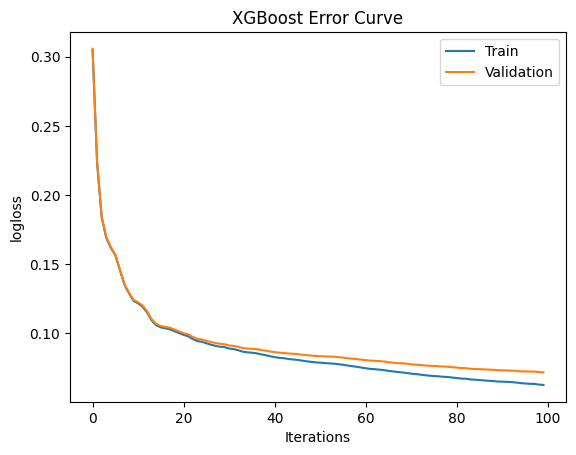

In [21]:
plot_training_error_curves(history)

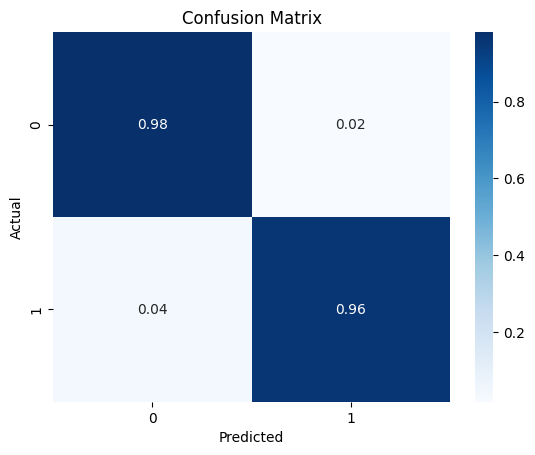

In [22]:
# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show plot
plt.show()

In [23]:
y_pred_class = xgb_clf.predict(X_test)
y_pred_scores = xgb_clf.predict_proba(X_test)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)


Train Loss:       0.0627
Validation Loss:  0.0718

Performance no conjunto de teste:


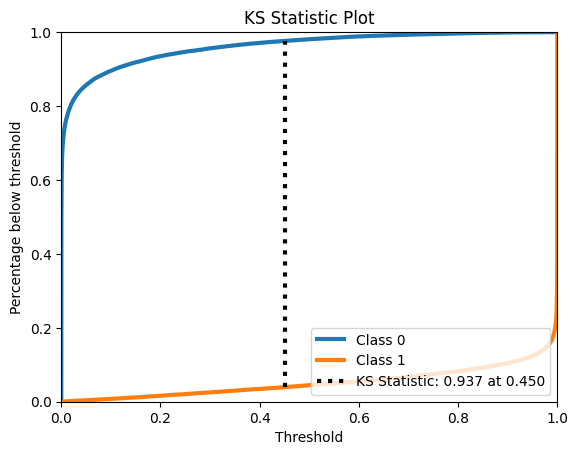


Accuracy:         0.9697
Recall:           0.9554
Precision:        0.9743
F1:               0.9647
AUROC:            0.9965
AUPR:             0.9959


In [24]:
## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(history, X_test, y_test)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Otimização de hyperparametros com hyperopt

In [22]:
!pip install hyperopt


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from hyperopt import space_eval
import hyperopt.pyll.stochastic

In [24]:
# Função objetivo para o Hyperopt
def objective(params):
    model = create_xgb_model(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [25]:
objective(params)

{'loss': -0.9582306744687403, 'status': 'ok'}

In [26]:
space = {
    'eval_metric': hp.choice('eval_metric', ['error', 'logloss', 'auc']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'alpha': hp.uniform('alpha', 0.0, 1.0),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart'])
}

In [28]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

  0%|          | 0/50 [13:46<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [199]:
best_params = space_eval(space, best)
final_model = xgb.XGBClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)

XGBClassifier(alpha=0.43030369185329154, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7229139255628805, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08195677717847881,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=232, n_jobs=-1,
              num_parallel_tree=None, ...)

In [200]:
y_pred_final = final_model.predict(X_val)
accuracy_final = accuracy_score(y_val, y_pred_final)
print(f'Final Accuracy: {accuracy_final}')

Final Accuracy: 0.9646596858638743


In [29]:
import pickle

# Save the model to a file
with open('models/final_model_xgboost.pkl', 'wb') as file:
    pickle.dump(xgb_clf, file)

# Explainability

## Global Explainability

In [26]:
import pickle
with open('models/final_model_xgboost.pkl', 'rb') as file:
    xg_boost = pickle.load(file)

In [27]:
X_train.columns

Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Gender_Female', 'Gender_Male',
       'Customer Type_Loyal Customer', 'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'Class_Business', 'Class_Eco', 'Class_Eco Plus',
       'Departure Delay Category_10 minutos até 30 minutos',
       'Departure Delay Category_30 min até 1 hora',
       'Departure Delay Category_Mais de 1 hora',
       'Departure Delay Category_Menos de 10 minutos',
       'Arrival Delay Category_10 minutos até 30 minutos',
       'Arrival Delay Category_30 min até 1 hora',
       'Arrival Delay Category_Mais de 1 hora',
       'Arrival Dela

Nossa implementação do PFI

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Define as features numéricas (não passaram por one-hot encoding)
numerical_features = [
    'Age', 'Flight Distance', 'Inflight wifi service', 
    'Departure/Arrival time convenient', 'Ease of Online booking', 
    'Gate location', 'Food and drink', 'Online boarding', 
    'Seat comfort', 'Inflight entertainment', 'On-board service', 
    'Leg room service', 'Baggage handling', 'Checkin service', 
    'Inflight service', 'Cleanliness'
]

# Define os grupos de features categóricas baseadas no one-hot encoding
categorical_feature_groups = {
    'Customer Type': ['Customer Type_Loyal Customer', 'Customer Type_disloyal Customer'],
    'Class': ['Class_Business', 'Class_Eco', 'Class_Eco Plus'],
    'Type of Travel': ['Type of Travel_Business travel', 'Type of Travel_Personal Travel'],
    'Departure Delay Category': [
        'Departure Delay Category_10 minutos até 30 minutos', 
        'Departure Delay Category_30 min até 1 hora',
        'Departure Delay Category_Mais de 1 hora', 
        'Departure Delay Category_Menos de 10 minutos'],
    'Arrival Delay Category': [
        'Arrival Delay Category_10 minutos até 30 minutos', 
        'Arrival Delay Category_30 min até 1 hora',
        'Arrival Delay Category_Mais de 1 hora', 
        'Arrival Delay Category_Menos de 10 minutos'],
    'Gender': ['Gender_Female', 'Gender_Male']
}

# Function to compute PFI for grouped one-hot encoded features
def compute_pfi_combined(model, X_test, y_test, numerical_features, categorical_groups, metric=accuracy_score):
    """
    Calcula a Importância de Feature por Permutação (PFI) para um modelo XGBoost,
    considerando tanto features numéricas quanto categóricas (agrupadas para one-hot encoded).
    
    Args:
    - model: Modelo XGBoost treinado
    - X_test: Dataset de teste (DataFrame)
    - y_test: Labels verdadeiras
    - numerical_features: Lista de features numéricas
    - categorical_groups: Dicionário onde as chaves são os nomes originais das features categóricas, e os valores são listas de colunas one-hot encoded.
    - metric: Métrica de avaliação (padrão é accuracy_score)
    
    Returns:
    - importance_df: DataFrame com as importâncias das features
    """
    # Compute original predictions and accuracy
    original_preds = model.predict(X_test)
    original_score = metric(y_test, np.round(original_preds))

    feature_importances = {}

    # Primeiro, permutamos as features numéricas individualmente
    for feature in numerical_features:
        X_permuted = X_test.copy()
        
        # Permuta a coluna numérica
        X_permuted[feature] = shuffle(X_permuted[feature].values, random_state=42)
        
        # Predição com dataset permutado
        permuted_preds = model.predict(X_permuted)
        permuted_score = metric(y_test, np.round(permuted_preds))
        
        # A importância é a diferença entre a métrica original e a métrica permutada
        feature_importances[feature] = original_score - permuted_score

    # Agora, permutamos as features categóricas como grupos
    for feature, columns in categorical_groups.items():
        X_permuted = X_test.copy()
        
        # Permuta todas as colunas one-hot correspondentes a essa feature
        X_permuted[columns] = shuffle(X_permuted[columns].values, random_state=42)
        
        # Predição com dataset permutado
        permuted_preds = model.predict(X_permuted)
        permuted_score = metric(y_test, np.round(permuted_preds))
        
        # A importância é a diferença entre a métrica original e a métrica permutada
        feature_importances[feature] = original_score - permuted_score

    # Converte para DataFrame para melhor visualização
    importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

# Chame a função para calcular PFI
importance_df = compute_pfi_combined(xgb_clf, X_test, y_test, numerical_features, categorical_feature_groups)

# Mostra as importâncias calculadas
print(importance_df)

                              Feature  Importance
2               Inflight wifi service    0.177221
18                     Type of Travel    0.144114
16                      Customer Type    0.068063
7                     Online boarding    0.031029
12                   Baggage handling    0.027015
14                   Inflight service    0.026370
13                    Checkin service    0.020230
8                        Seat comfort    0.016246
15                        Cleanliness    0.015303
5                       Gate location    0.012829
9              Inflight entertainment    0.011414
17                              Class    0.011232
0                                 Age    0.010962
10                   On-board service    0.008267
1                     Flight Distance    0.007699
4              Ease of Online booking    0.005495
11                   Leg room service    0.005168
3   Departure/Arrival time convenient    0.003340
20             Arrival Delay Category    0.002599


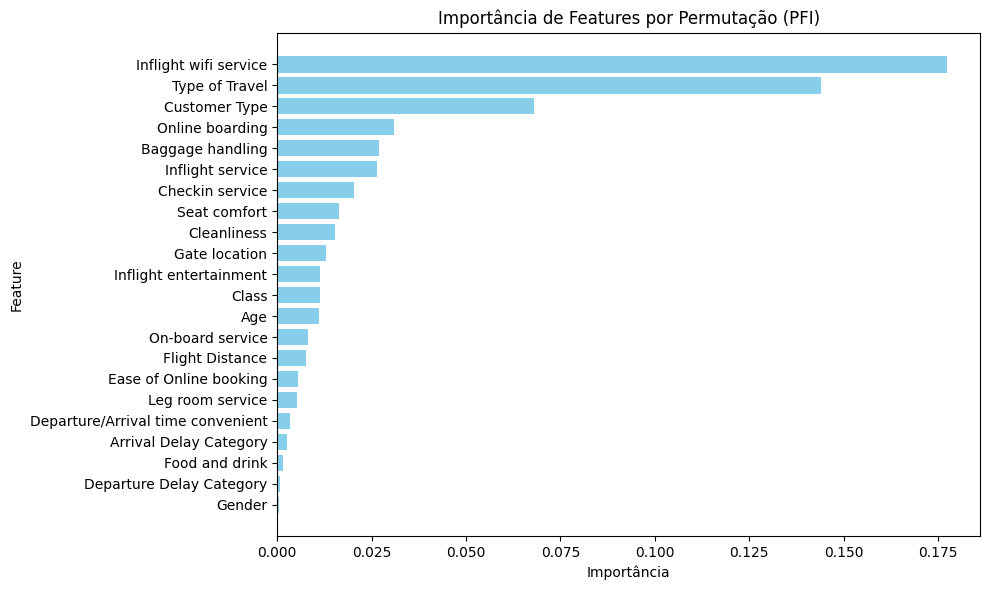

In [29]:
import matplotlib.pyplot as plt

def plot_pfi(importance_df):
    """
    Plota um gráfico de barras para a Importância de Feature por Permutação (PFI).
    
    Args:
    - importance_df: DataFrame contendo as colunas 'Feature' e 'Importance'
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.title('Importância de Features por Permutação (PFI)')
    plt.gca().invert_yaxis()  # Inverte o eixo para a maior importância aparecer no topo
    plt.tight_layout()
    plt.show()

# Exemplo: Substitua pela sua tabela 'importance_df' real
plot_pfi(importance_df)


definimos uma função para plotar os gráficos de dependencia parcial para as features que sofreram one-hot-encoding no treinamento.


nos baseamos na teoria apresentada no livro *Interpretable Machine Learning* em que ele fala

*Categorical features*

*For categorical features, the partial dependence is very easy to calculate. For each of the categories, we get a PDP estimate by **forcing all data instances to have the same category**.*

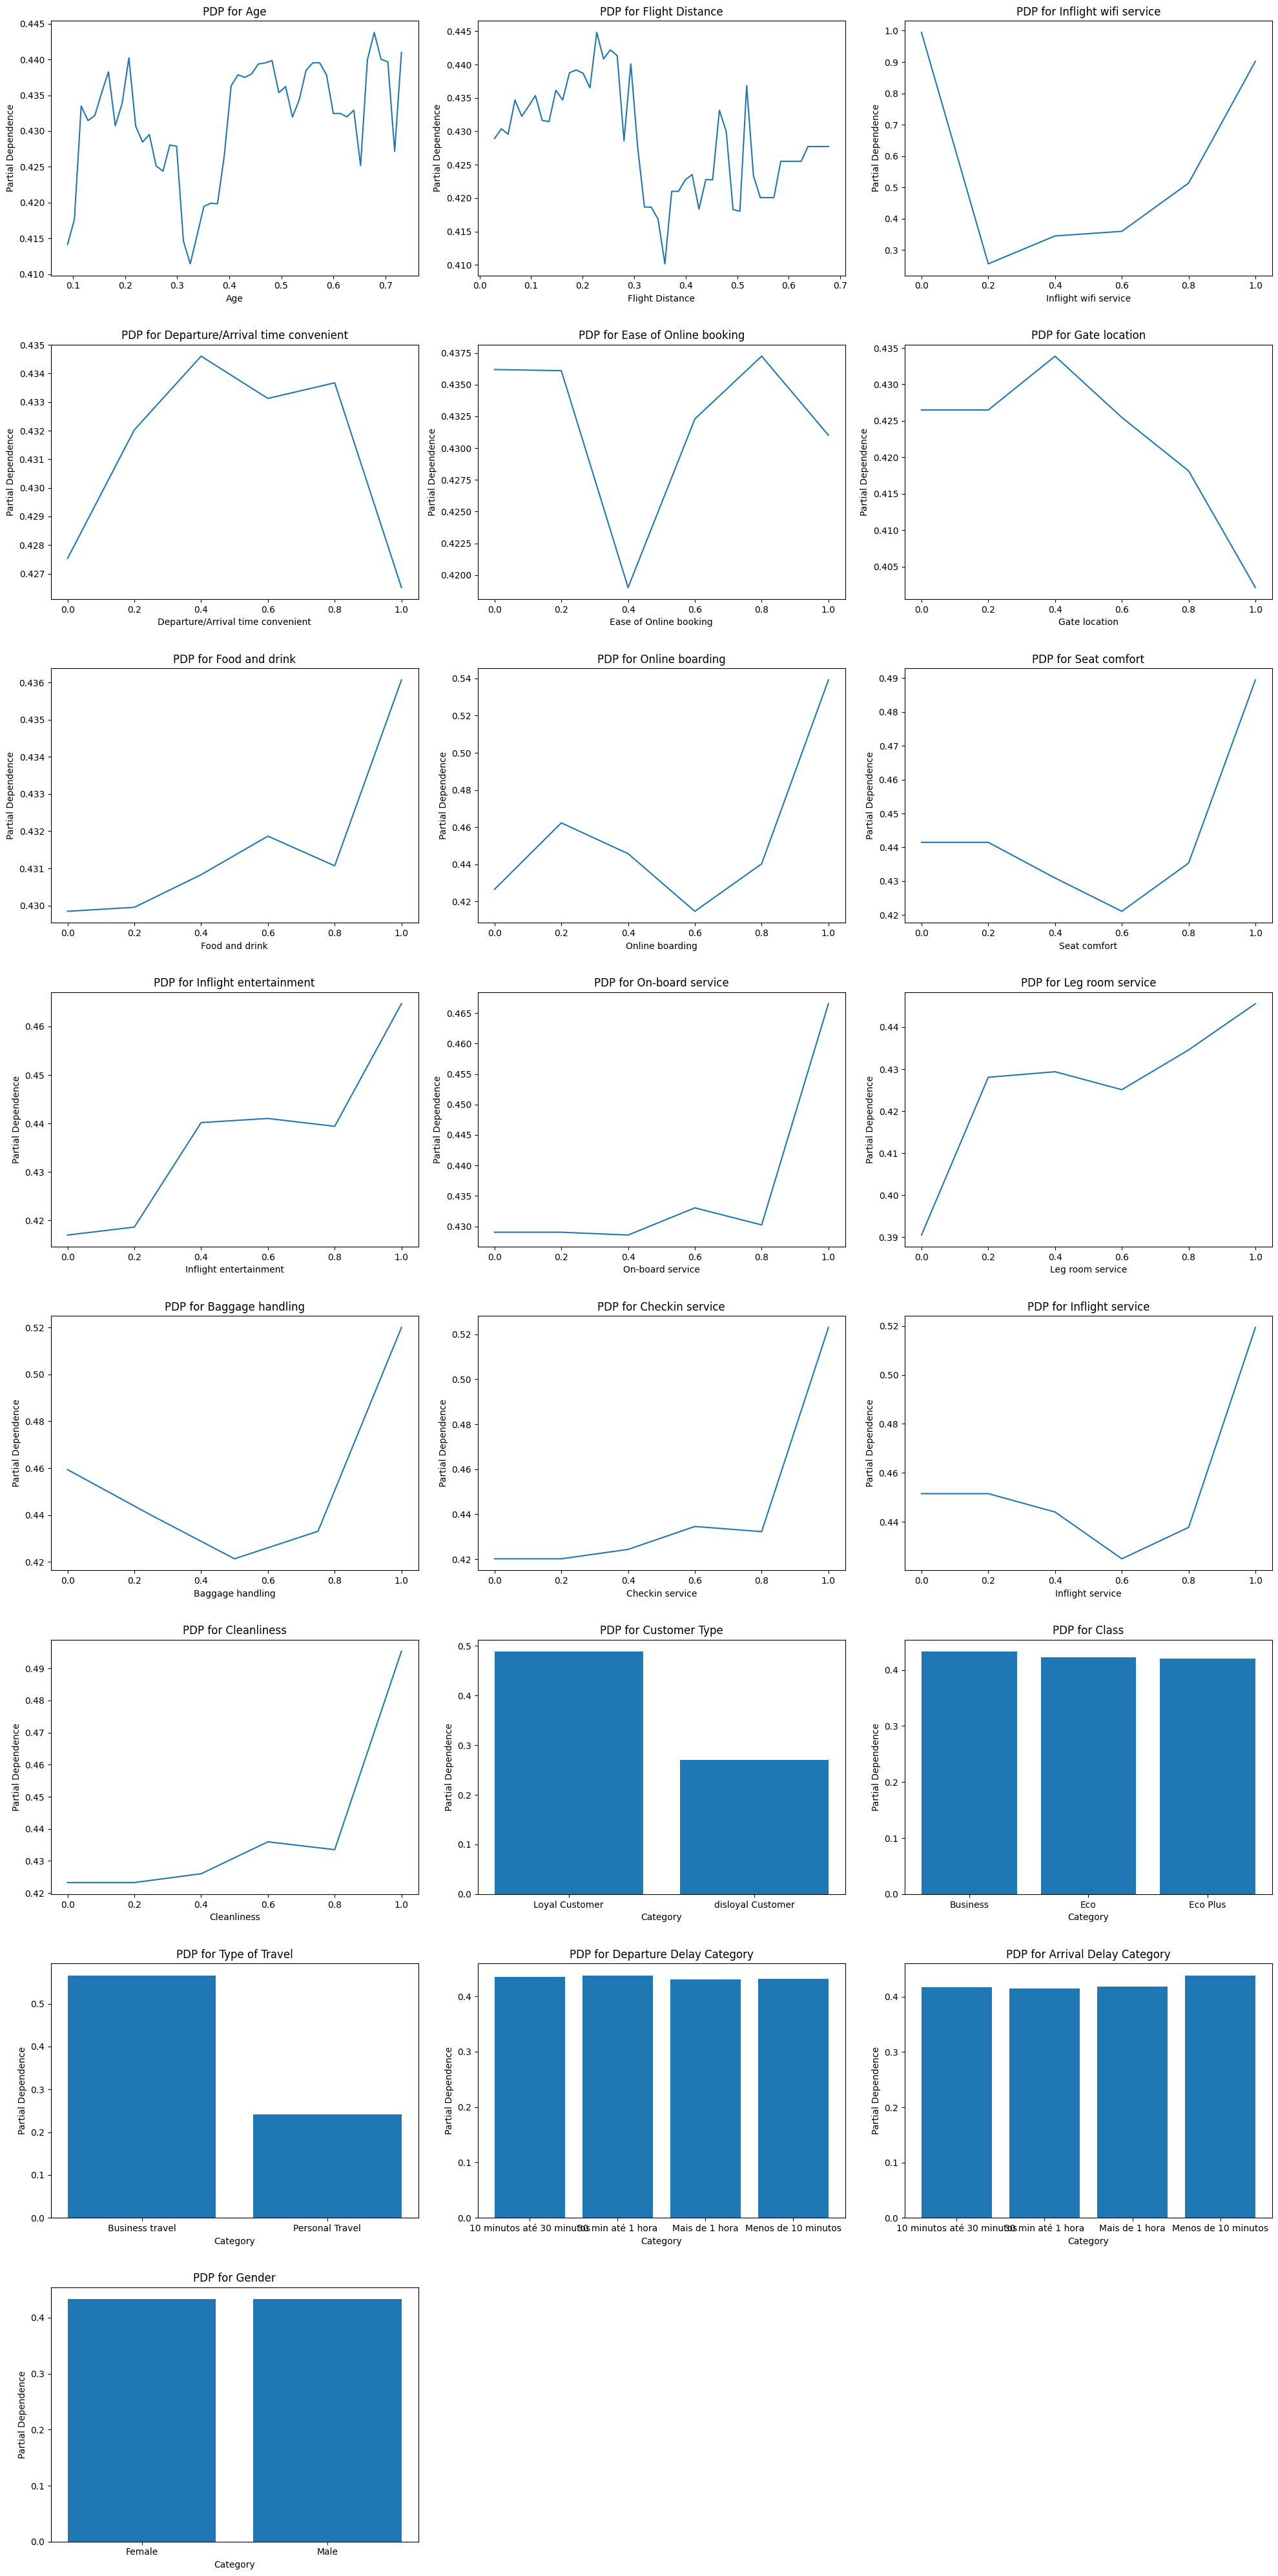

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import partial_dependence

def plot_pdp_grid(model, X_test, numerical_features, categorical_feature_groups, grid_resolution=50):
    """
    Função para plotar Partial Dependence Plots (PDP) para features numéricas e categóricas agrupadas.
    
    Args:
    - model: O modelo treinado.
    - X_test: O conjunto de dados de teste.
    - numerical_features: Lista de nomes de features numéricas.
    - categorical_feature_groups: Dicionário contendo mapeamentos de grupos de features categóricas (one-hot encoded) para suas categorias originais.
    - grid_resolution: Resolução da grade para PDP (opcional, padrão = 50).
    """
    # Calcula o número total de gráficos
    num_plots = len(numerical_features) + len(categorical_feature_groups)
    
    # Configura o número de colunas (4 por linha)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calcula o número de linhas necessário

    # Cria o grid de subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plota PDPs para features numéricas
    for i, feature in enumerate(numerical_features):
        display = partial_dependence(
            model, X_test, features=[feature], grid_resolution=grid_resolution
        )
        ax = axes[i]
        ax.plot(display['values'][0], np.mean(display['average'], axis=0))
        ax.set_title(f'PDP for {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Partial Dependence')

 # Plota PDPs para features categóricas agrupadas
    for j, (group_name, group_columns) in enumerate(categorical_feature_groups.items(), start=len(numerical_features)):
        pdp_values = []
        column_labels = [col.split('_')[-1] for col in group_columns]  # Extrai o nome da categoria após o último underline
        
        for category_column in group_columns:
            X_temp = X_test.copy()
            X_temp[group_columns] = 0.0    # Zera as colunas no grupo
            X_temp[category_column] = 1.0  # Força o valor da coluna para a categoria específica
            
            # Adiciona o PDP do modelo para essa categoria
            display = partial_dependence(model, X_temp, features=[category_column])
            pdp_values.append(np.mean(display['average']))  # Média da dependência parcial

        # Plota o gráfico PDP para o grupo categórico
        ax = axes[j]
        ax.bar(column_labels, pdp_values)  # Usa os labels extraídos
        ax.set_title(f'PDP for {group_name}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Partial Dependence')
    
    
    # Remove eixos extras se houver
    for k in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[k])
    
    plt.tight_layout(h_pad=3)
    plt.show()


# Define numerical and categorical features (grouped by one-hot encoding)
numerical_features = [
    'Age', 'Flight Distance', 'Inflight wifi service', 
    'Departure/Arrival time convenient', 'Ease of Online booking', 
    'Gate location', 'Food and drink', 'Online boarding', 
    'Seat comfort', 'Inflight entertainment', 'On-board service', 
    'Leg room service', 'Baggage handling', 'Checkin service', 
    'Inflight service', 'Cleanliness'
]

categorical_feature_groups = {
    'Customer Type': ['Customer Type_Loyal Customer', 'Customer Type_disloyal Customer'],
    'Class': ['Class_Business', 'Class_Eco', 'Class_Eco Plus'],
    'Type of Travel': ['Type of Travel_Business travel', 'Type of Travel_Personal Travel'],
    'Departure Delay Category': [
        'Departure Delay Category_10 minutos até 30 minutos', 
        'Departure Delay Category_30 min até 1 hora',
        'Departure Delay Category_Mais de 1 hora', 
        'Departure Delay Category_Menos de 10 minutos'],
    'Arrival Delay Category': [
        'Arrival Delay Category_10 minutos até 30 minutos', 
        'Arrival Delay Category_30 min até 1 hora',
        'Arrival Delay Category_Mais de 1 hora', 
        'Arrival Delay Category_Menos de 10 minutos'],
    'Gender': ['Gender_Female', 'Gender_Male']
}

# Call the function to plot PDPs in grid
plot_pdp_grid(xgb_clf, X_test, numerical_features, categorical_feature_groups)


Aparentemente ter wifi no avião influencia muito a previsão do modelo, imagina por que será que estar conectado com o resto do mundo influencia no humor das pessoas? 

a feature de wifi na verdade não é binaria como parece, mas é o uma nota de 0 a 5 que os usuarios podem dar para o serviço de wifi, vamos fazer um PDP para entender melhor

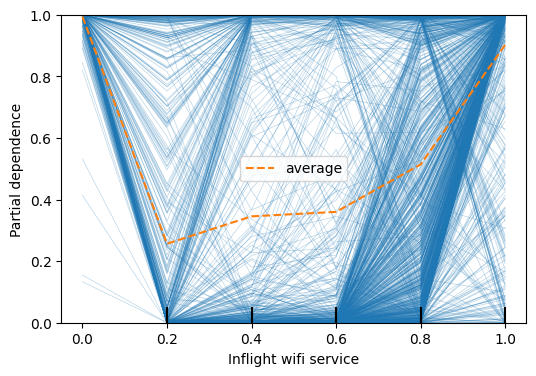

In [30]:
from sklearn.inspection import PartialDependenceDisplay
disp1 = PartialDependenceDisplay.from_estimator(xgb_clf, X_test, [2], kind='both')

Vemos um grafico com formato de "V" para a media das instancias ou seja as pontas são bem mais faceis de prever do que o meio, faz sentido que seja assim, quem deu 5 estrelas para o wifi gostou do vôo, mas quem deu 0 não gostou. Além disso as pessoas que deram 0 estrelas parecem ser muito faceis de prever, vejamos sua destribuição:

In [74]:
# Filter the rows of Y_test that correspond to 'bad_wifi' in X_test
bad_wifi_indices = X_test[X_test['Inflight wifi service'] == 0].index
bad_wifi_Y_test = y_test.loc[bad_wifi_indices]

# Now, you can view the distribution of the filtered Y_test values
distribution = bad_wifi_Y_test.value_counts()
print(distribution)

satisfied
1    3095
0       8
Name: count, dtype: int64


Descoberta impressionante: na verdade, a maioria esmagadora das pessoas que da 0 estrelas para o wifi está dando que está satisfeita com o vôo e o modelo aprendeu isso. Isso talvez seja falha nos dados ou na forma como foi coletado, não sei dizer ao certo 

outra feature relevante é o tipo de viagem, se é a negocios ou pessoal, vai ser interessante entender o por que disso, é de se pensar que pessoas a trabalho tenham interesses difenrentes de pessoas a lazer, ou talvez pessoas a lazer não sejam rigorosas com o review e tendem a dar mais notas positivasolhando os dois PDP acima vemos que o tipo de viagem a negocios tem uma correlação positiva com a predição do modelo, enquanto viagem a pessoas não parece aprensentar nenhuma correlação, eu penso que viagens pessoas englobam estilos de viagem tão difenretes que deve ser mais dificil prever o que esse publico prefere

Ricardo pode viajar para as ilhas gregas para turismo, ou para um tratamento de saúde ou para participar de um funeral, talvez Ricardo estaja com muita pressa, talvez não, então o humor e a expectiva do cliente em vôos deve variar tanto que o modelo não consegue aprender muita coisa com esse fato

### Gráficos PDP comparando voos a negocio e voos pessoais

Agora se nos olharmos para os **viajantes a negocios**, quando ricardo vai às Ilhas Gregas para uma conferência! O que o modelo usa para prever o seu gosto?

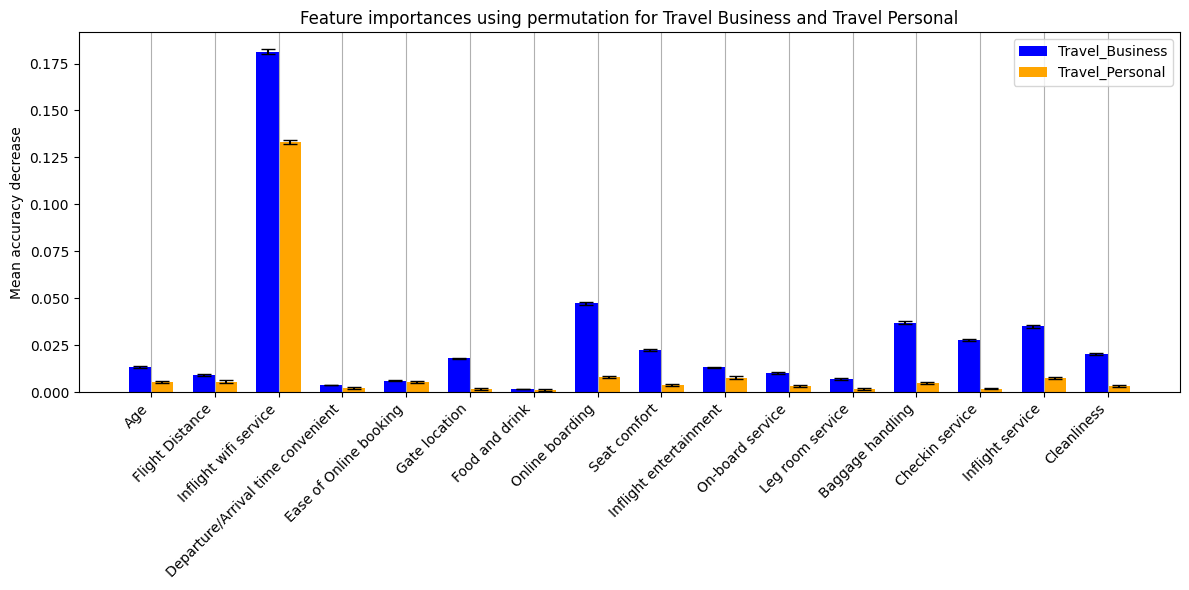

In [31]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate permutation importance for male
result_a = permutation_importance(xg_boost, X_test[X_test['Type of Travel_Business travel'] == 1], y_test[X_test['Type of Travel_Business travel'] == 1], n_repeats=100, random_state=0)

# Calculate permutation importance for female
result_b = permutation_importance(xg_boost, X_test[X_test['Type of Travel_Personal Travel'] == 1], y_test[X_test['Type of Travel_Personal Travel'] == 1], n_repeats=100, random_state=0)

# Only select the first 16 columns (0 to 16)
columns_to_display = X_train.columns[:16]
importances_mean_male = result_a.importances_mean[:16]
importances_std_male = result_a.importances_std[:16]
importances_mean_female = result_b.importances_mean[:16]
importances_std_female = result_b.importances_std[:16]

# Create pandas Series for the importances for male and female
forest_importances_male = pd.Series(importances_mean_male, index=columns_to_display)
forest_importances_female = pd.Series(importances_mean_female, index=columns_to_display)

# Create a single figure with subplots
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size

# Set the width of the bars
bar_width = 0.35

# Plot the male importances
bars_male = ax.bar(np.arange(len(forest_importances_male)), forest_importances_male, width=bar_width, 
                   label='Travel_Business', yerr=importances_std_male, capsize=5, color='blue')

# Plot the female importances, shifted by bar_width
bars_female = ax.bar(np.arange(len(forest_importances_female)) + bar_width, forest_importances_female, width=bar_width, 
                     label='Travel_Personal', yerr=importances_std_female, capsize=5, color='orange')

# Set plot titles and labels
ax.set_title("Feature importances using permutation for Travel Business and Travel Personal")
ax.set_ylabel("Mean accuracy decrease")
ax.set_xticks(np.arange(len(forest_importances_male)) + bar_width / 2)
ax.set_xticklabels(columns_to_display, rotation=45, ha="right")

# Add a legend to differentiate between male and female
ax.legend()

# Display grid for x-axis
ax.grid(True, axis='x')

# Adjust layout to prevent clipping
fig.tight_layout()

# Show the plot
plt.show()


Parece ser mais facil prever o que satisfaz um cliente viajando a trabalho feliz do que um cliente viajando a lazer, talvez isso seja por causa da distribuição:

In [63]:
X_test[X_test['Type of Travel_Business travel'] == 1].shape[0], X_test[X_test['Type of Travel_Personal Travel'] == 1].shape[0]

(71655, 32249)

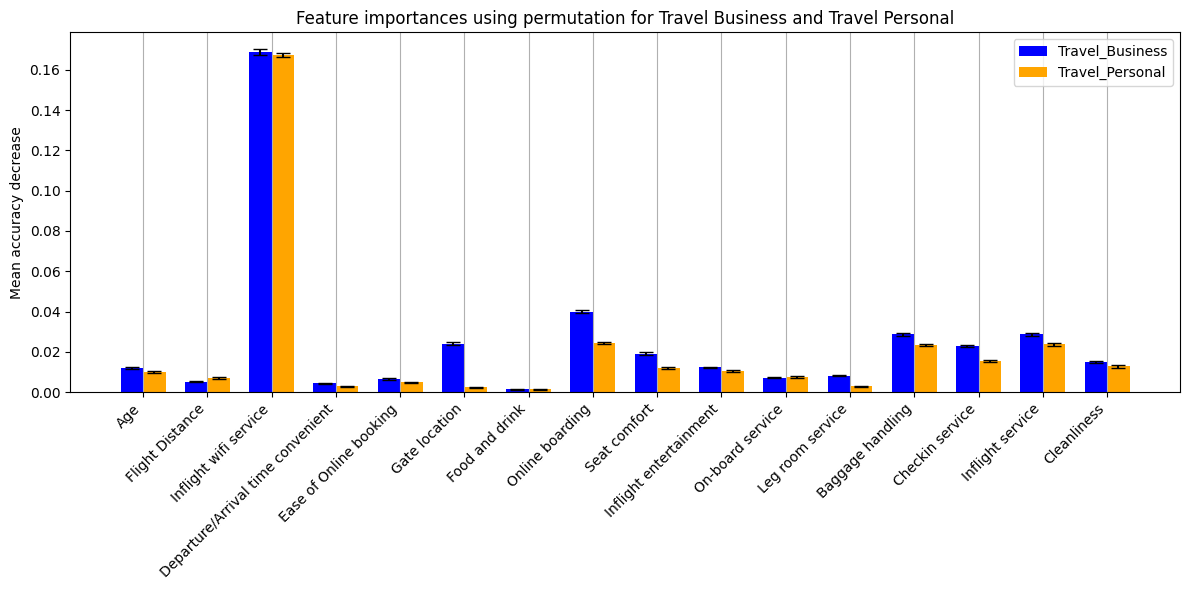

In [64]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate permutation importance for male
result_a = permutation_importance(xg_boost, X_test[X_test['Class_Business'] == 1], y_test[X_test['Class_Business'] == 1], n_repeats=100, random_state=0)

# Calculate permutation importance for female
result_b = permutation_importance(xg_boost, X_test[X_test['Class_Eco'] == 1], y_test[X_test['Class_Eco'] == 1], n_repeats=100, random_state=0)

# Only select the first 16 columns (0 to 16)
columns_to_display = X_train.columns[:16]
importances_mean_male = result_a.importances_mean[:16]
importances_std_male = result_a.importances_std[:16]
importances_mean_female = result_b.importances_mean[:16]
importances_std_female = result_b.importances_std[:16]

# Create pandas Series for the importances for male and female
forest_importances_male = pd.Series(importances_mean_male, index=columns_to_display)
forest_importances_female = pd.Series(importances_mean_female, index=columns_to_display)

# Create a single figure with subplots
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size

# Set the width of the bars
bar_width = 0.35

# Plot the male importances
bars_male = ax.bar(np.arange(len(forest_importances_male)), forest_importances_male, width=bar_width, 
                   label='Travel_Business', yerr=importances_std_male, capsize=5, color='blue')

# Plot the female importances, shifted by bar_width
bars_female = ax.bar(np.arange(len(forest_importances_female)) + bar_width, forest_importances_female, width=bar_width, 
                     label='Travel_Personal', yerr=importances_std_female, capsize=5, color='orange')

# Set plot titles and labels
ax.set_title("Feature importances using permutation for Travel Business and Travel Personal")
ax.set_ylabel("Mean accuracy decrease")
ax.set_xticks(np.arange(len(forest_importances_male)) + bar_width / 2)
ax.set_xticklabels(columns_to_display, rotation=45, ha="right")

# Add a legend to differentiate between male and female
ax.legend()

# Display grid for x-axis
ax.grid(True, axis='x')

# Adjust layout to prevent clipping
fig.tight_layout()

# Show the plot
plt.show()

In [32]:
X_test[X_test['Type of Travel_Business travel'] == 1].shape[0], X_test[X_test['Type of Travel_Personal Travel'] == 1].shape[0], 

(71655, 32249)

## Local Explainability